# Advanced Lane Finding Project (Finding Lane line / Warp image Part3)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## TestImage Pipeline ##

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

import pickle
import sys

import os
import pandas as pd
import matplotlib.gridspec as gridspec

import seaborn as sns

from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure
from skimage.io import imread, imsave

from scipy.ndimage.interpolation import rotate

from utils import showImageList
from utils import pipelineBinaryImage
from utils import pipelineBinaryImage3
from utils import pipelineBinaryImage4

import platform

%matplotlib inline


***
##   pipelineBinaryImage definition 
***
* normal image to sobelx   
* S channel of HLS binary filtering. 
* then make binary including those 2 categorical mask 

***
##   pipelineBinaryImage2 definition 
***
* l channel of HLS applied to sobelx  
* S channel of HLS binary filtering. 
* then make binary including those 2 categorical mask

### common function to set threshhold values ###

## load saved pickle camera calibration parameters ##

In [2]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./pickled_data/calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


# Load Test images and undistortion images from saved directory #

In [3]:
#
# load test images from test_images directory
#
# read with skimage.io.imread (RGB mode)

filenames = sorted( os.listdir("./test_images/") )
images = list( map( lambda x: imread( os.path.join("./test_images",x)), filenames) )

#undistort_filenames = sorted( os.listdir("./undistort/") )
#undistort_images = list( map( lambda x: imread( os.path.join("./undistort",x)), filenames) )

undist_ops = lambda img:cv2.undistort(img, mtx, dist, None, mtx)
undist_images = list( map( undist_ops, images ) )

gray_ops = lambda im:cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
undist_gray_images = list( map( gray_ops, undist_images ) )


#displayImage2x4(filenames,images, "Original Test Images = 8 images ")

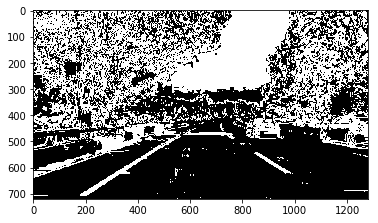

In [4]:
binary=pipelineBinaryImage(undist_images[6])
plt.imshow(binary,cmap="gray")

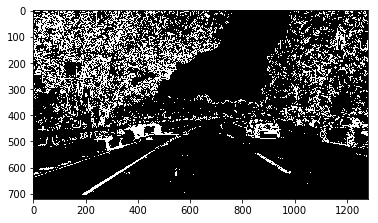

In [5]:
colored,binary=pipelineBinaryImage4(undist_images[6])
plt.imshow(binary,cmap="gray")

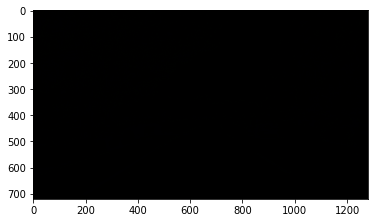

In [6]:
plt.imshow(colored)

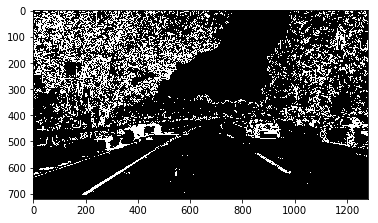

In [6]:
colored,binary=pipelineBinaryImage3(undistort_images[6])
plt.imshow(binary,cmap="gray")

## Draw the rectange lines for indentifying the lane lines on the road ##

* for the reference 

In [21]:
src = np.float32([[210, img_size[1]], [575, 460], 
                  [705, 460], [1090, img_size[1]]])

In [4]:


src = np.float32([[270,674],
                 [579,460],
                 [702,460],
                 [1035,674]])
dst = np.float32([[270,674],
                 [270,0],
                 [1035,0],
                 [1035,674]])

In [5]:
def M_gen(src,dst):
    
    # Given src and dst points, calculate the perspective transform matrix
    # source is 4 points trapezoid
    # destination is 4 points rectangle
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def warp_gen(img,M):
    # check out the image shape
    img_size = ( img.shape[1], img.shape[0] )
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped

def undistort_corners(img, mtx, dist):

    # images should be undistortion based on camera calibration.
    # incoming image is RGB format --> skimage.io.imread
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#### Source is common parameter for all of incoming test images 

In [7]:
def drawTapezoidPolygon(image,src):
    
    copy_image = np.copy(image)
    red = (255,0,0)
    pts = src.astype(np.int32).reshape((-1,1,2))
    polygon_image = cv2.polylines(copy_image ,[pts],True, red, thickness=3)
    return polygon_image


In [13]:
draw_ops = lambda im:drawTapezoidPolygon(im,src)
draw_images = list( map( draw_ops,undist_images ) )
draw_labels = list(map( lambda x:"cropped "+x , filenames ))

#draw_images_list =  np.asarray(list( zip(undist_images,draw_images) ))
#draw_images_label =  np.asarray(list( zip(filenames,draw_labels) ))

In [15]:
def makeBirdViewImages(images,src,dst,mtx,dist):

    warped_images = []
    for im in images:
        M, Minv = M_gen(src,dst)
        undist = undistort_corners(im, mtx, dist)
        warp_image = warp_gen(undist,M)
        warped_images.append(warp_image)
        
    return warped_images

In [43]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

laplacian_ops = lambda im:variance_of_laplacian(im)

def sharpen_image(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.filter2D(image, -1, kernel)
    return image

sharpen_image_ops = lambda im:sharpen_image(im)

In [16]:
# input is RGB image
warped_images = makeBirdViewImages(images,src,dst,mtx,dist)

In [17]:
warp_images_list =  np.asarray(list( zip(undist_images,draw_images,warped_images) ))
warp_labels = list(map( lambda x:"warped "+x , filenames ))
warp_images_label =  np.asarray(list( zip(filenames,draw_labels,warp_labels) ))

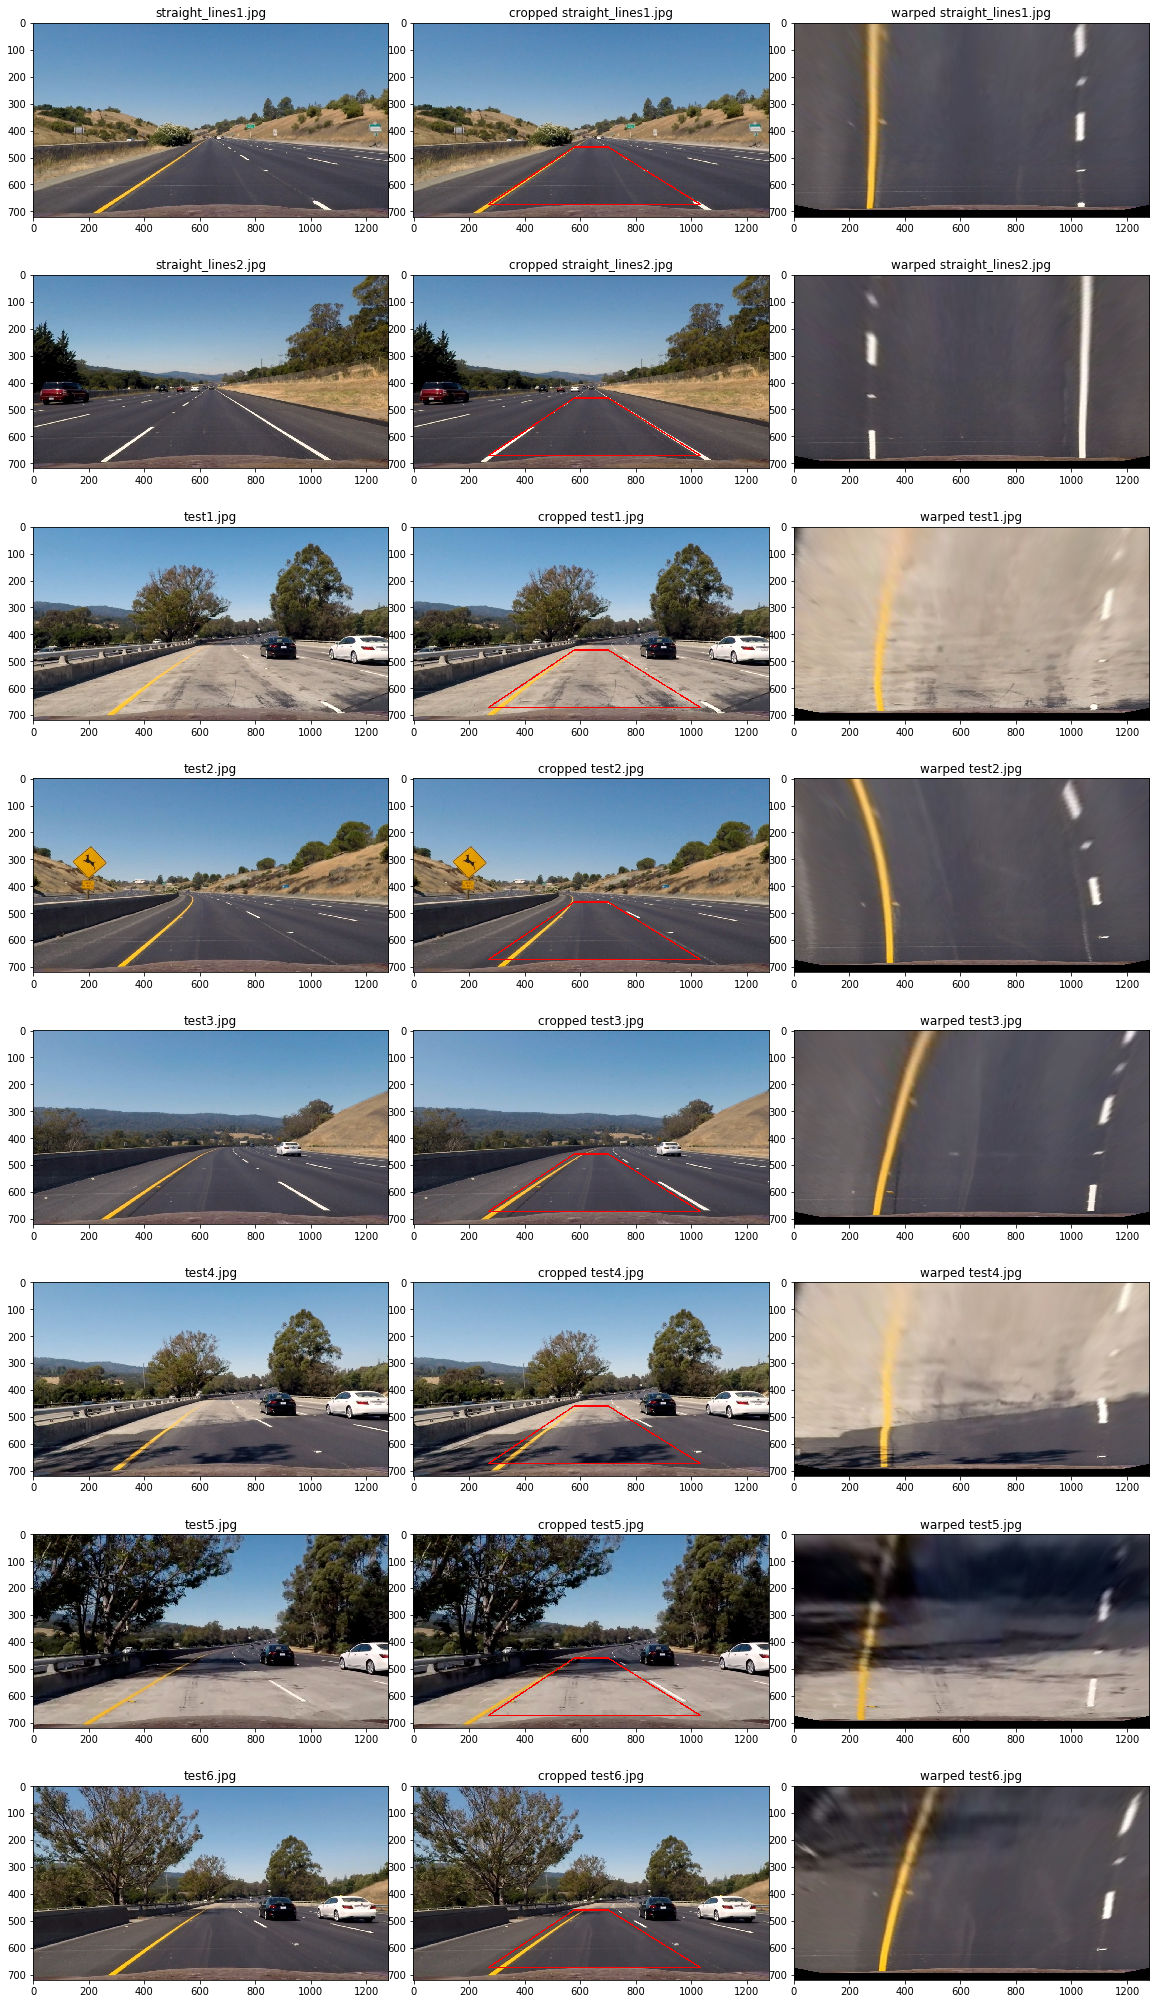

In [18]:
showImageList(warp_images_list, warp_images_label,cols=3,fig_size=(20, 36) )

## Check Laplacian Filter of Warped Images ##

In [39]:
warp_image_variance_of_laplacian =  list(map(laplacian_ops,warped_images))
print(warp_image_variance_of_laplacian)

# for reference of normal image
undist_image_variance_of_laplacian =  list(map(laplacian_ops,undist_images))
print(undist_image_variance_of_laplacian)

[39.79898000149197, 37.81739040026134, 54.90359877791111, 39.81957030119249, 39.12275390306637, 47.44090144896214, 42.32400514797634, 40.274308789937294]
[63.89524261745404, 90.7154377190378, 129.28678662561367, 64.30571047673988, 55.04968785396151, 132.15273612424002, 177.50480454312418, 204.41613618634557]


***
* After checking out how warped images are blurred with transformation process of warping from original tapezoid crop area, 
most of laplacian values are lower than original.
* If we apply sharpen warped images, it would be easy for extraction program to recognize the displayed lines as lane lines.

In [64]:
warped_sharpen_images = list(map( sharpen_image_ops, warped_images))
warped_sharpen_variance_of_laplacian =  list(map(laplacian_ops,warp_sharpen_images))


In [73]:
c, b =  pipelineBinaryImage4(images[0])


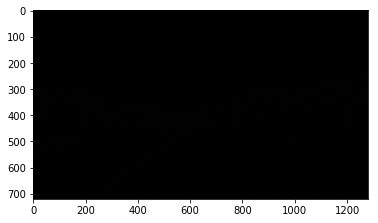

In [74]:
plt.imshow(c)

In [66]:
def 

binary_ops4 = lambda im:pipelineBinaryImage4(im)
(colored_lane_images,binary_lane_images) = list(map(binary_ops4,warped_images))


ValueError: too many values to unpack (expected 2)

In [48]:
binary_images_list =  np.asarray(list( zip(undist_gray_images,binary_lane_images) ))
binary_labels = list(map( lambda x:"Gradient Pipeline "+x , filenames ))
binary_images_label =  np.asarray(list( zip(filenames,binary_labels) ))

AttributeError: 'tuple' object has no attribute 'shape'

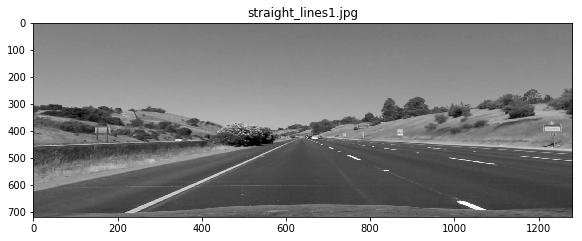

In [49]:
showImageList(binary_images_list, binary_images_label,cols=2,fig_size=(20, 36) )

### Check histogram of binary image axis=0 (x) from half size of image ###

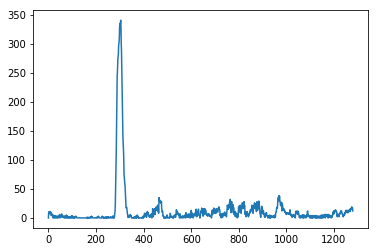

In [21]:
histogram1 = np.sum(binary1[  binary1.shape[0]//2:,:  ], axis=0)
plt.plot(histogram1)

In [23]:
def slidingWindow(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    #
    # Visualize 
    #
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, out_img
    
    


(720, 0)

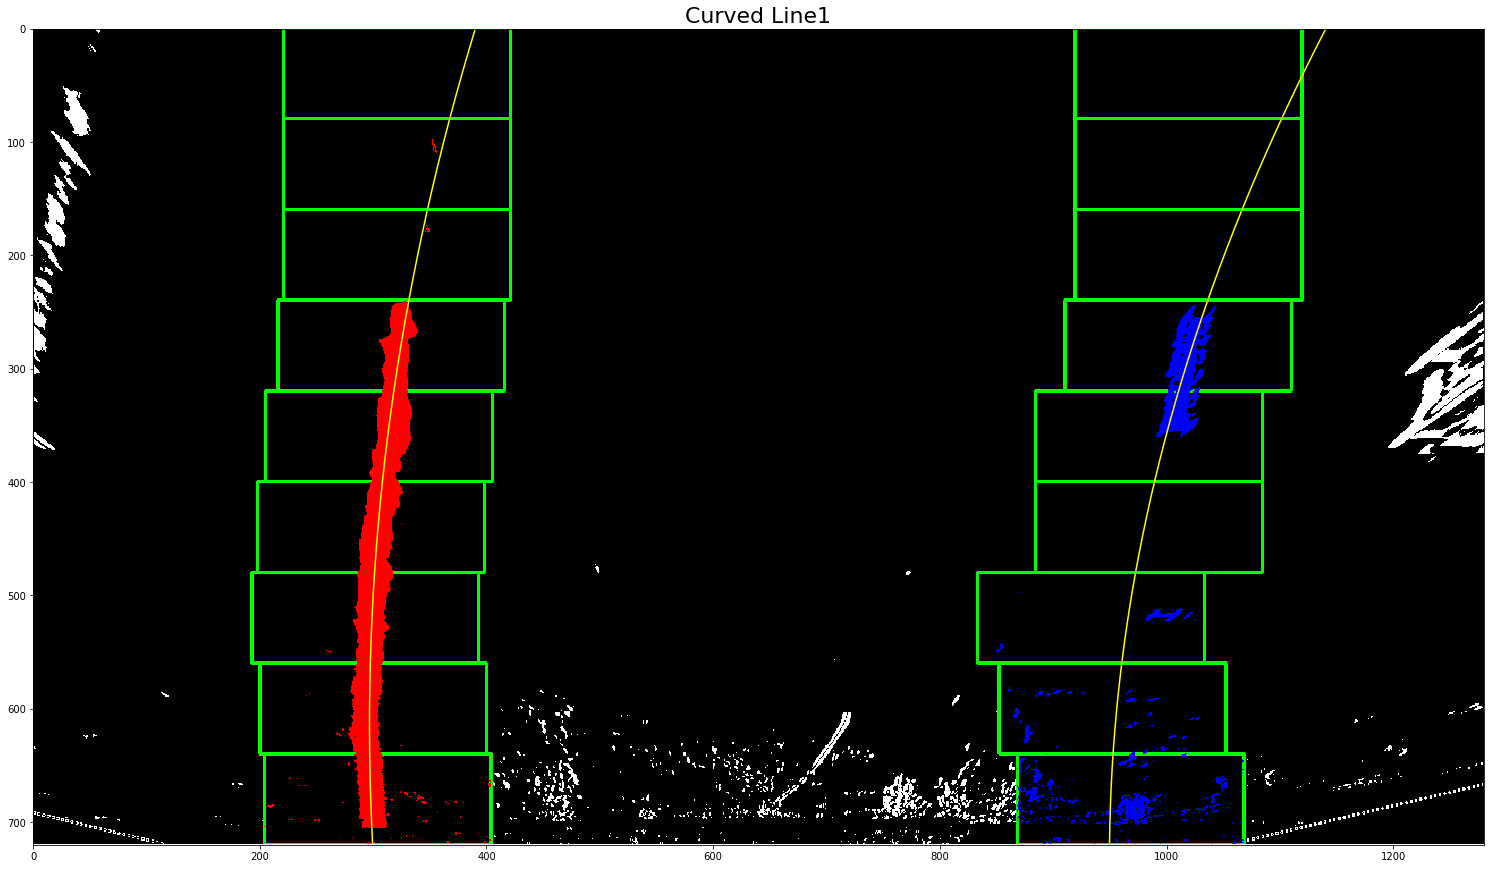

In [24]:
left_fit, right_fit, out_img = slidingWindow(binary1)

ploty = np.linspace(0, binary1.shape[0]-1, binary1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(26,20))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Curved Line1",fontsize="22")
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

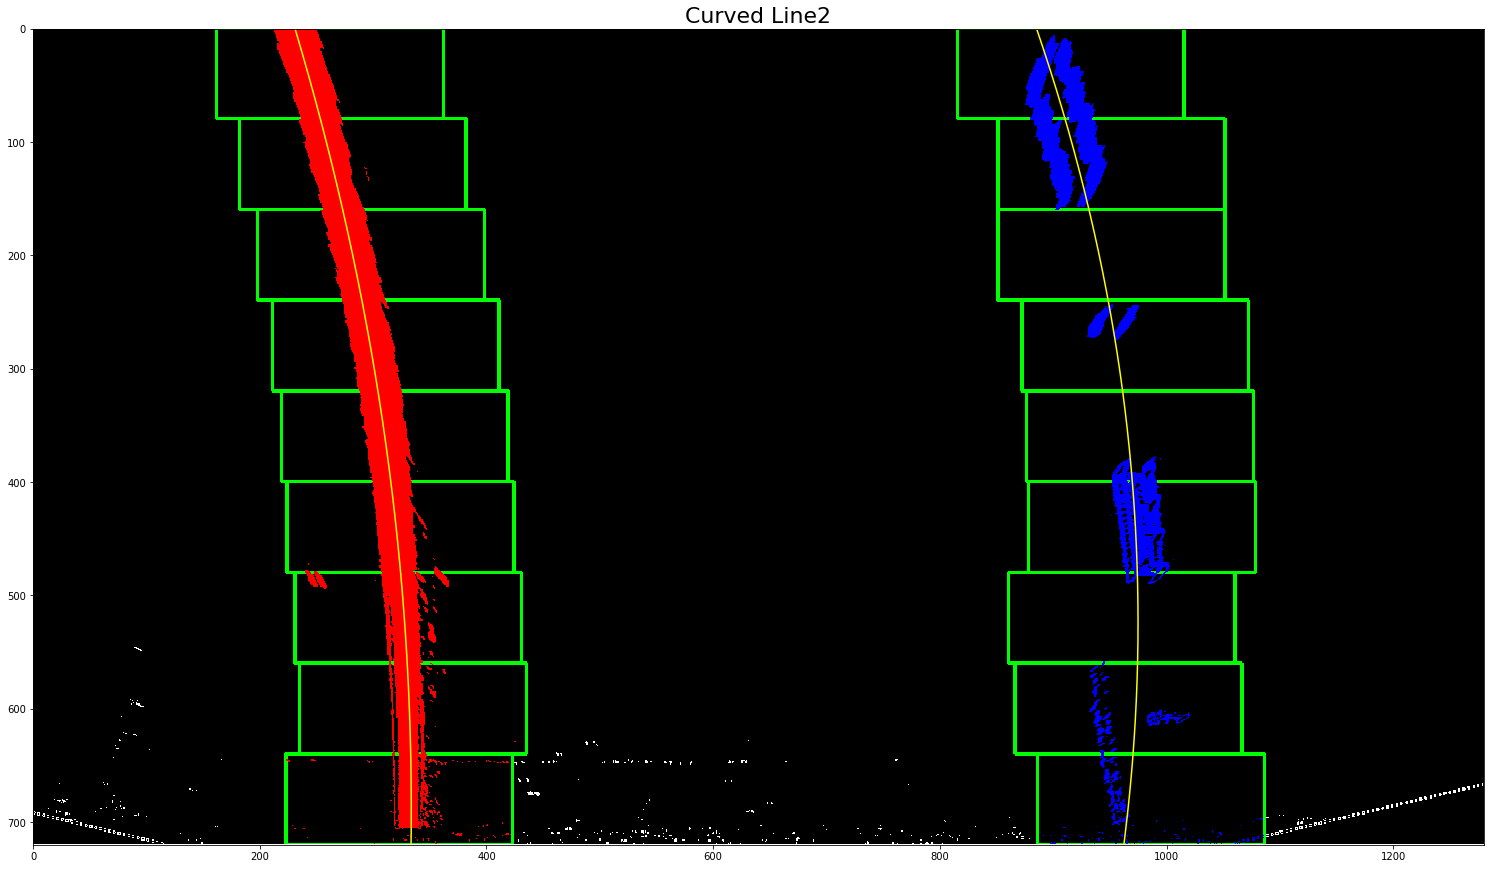

In [25]:
left_fit, right_fit, out_img = slidingWindow(binary2)

ploty = np.linspace(0, binary1.shape[0]-1, binary1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(26,20))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Curved Line2",fontsize="22")
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [30]:
binary_warped = binary2.copy()
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()

nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(array([  0,   0,   0, ..., 719, 719, 719]), array([ 212,  213,  214, ..., 1060, 1062, 1064]))
[ True  True  True ..., False False False]


(720, 0)

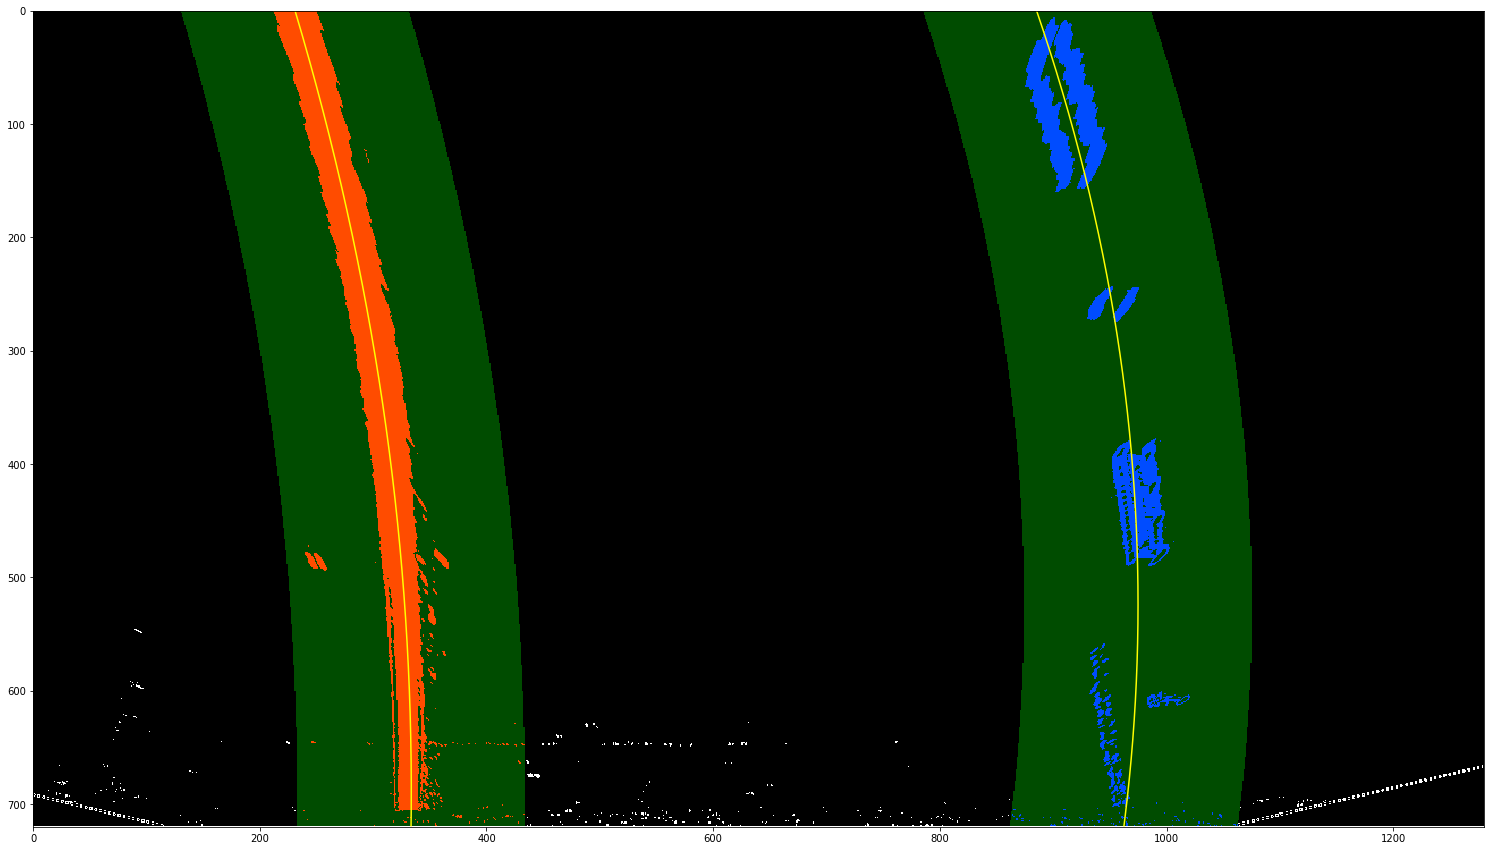

In [35]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(26,22))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Radius of Curvature ##


***

* Math Formulation is as follows
* A or B is fitting parameters. 
 $$R_{curve} = \frac{ (1 + (2Ay + B)^2) ^\frac{3}{2}  }{ |2A| } $$



In [36]:
y_eval = np.max(ploty)

In [39]:

print("left fit : ",left_fit)
print("right fit : ",right_fit)

left fit :  [ -2.16398369e-04   2.97941339e-01   2.31132762e+02]
right fit :  [ -3.25964777e-04   3.41583443e-01   8.85382543e+02]


In [40]:
# y_eval = maximum y value of input image 720 - 1 px( starting 0 )

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2311.16099058 1571.25863174


In [46]:
## So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

In [47]:
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

In [48]:

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

758.91247334 m 504.014045213 m


In [49]:
# %% Warp the detected lane boundaries back onto the original image
# # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(result, np.int_([pts]), (0,255, 0))


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

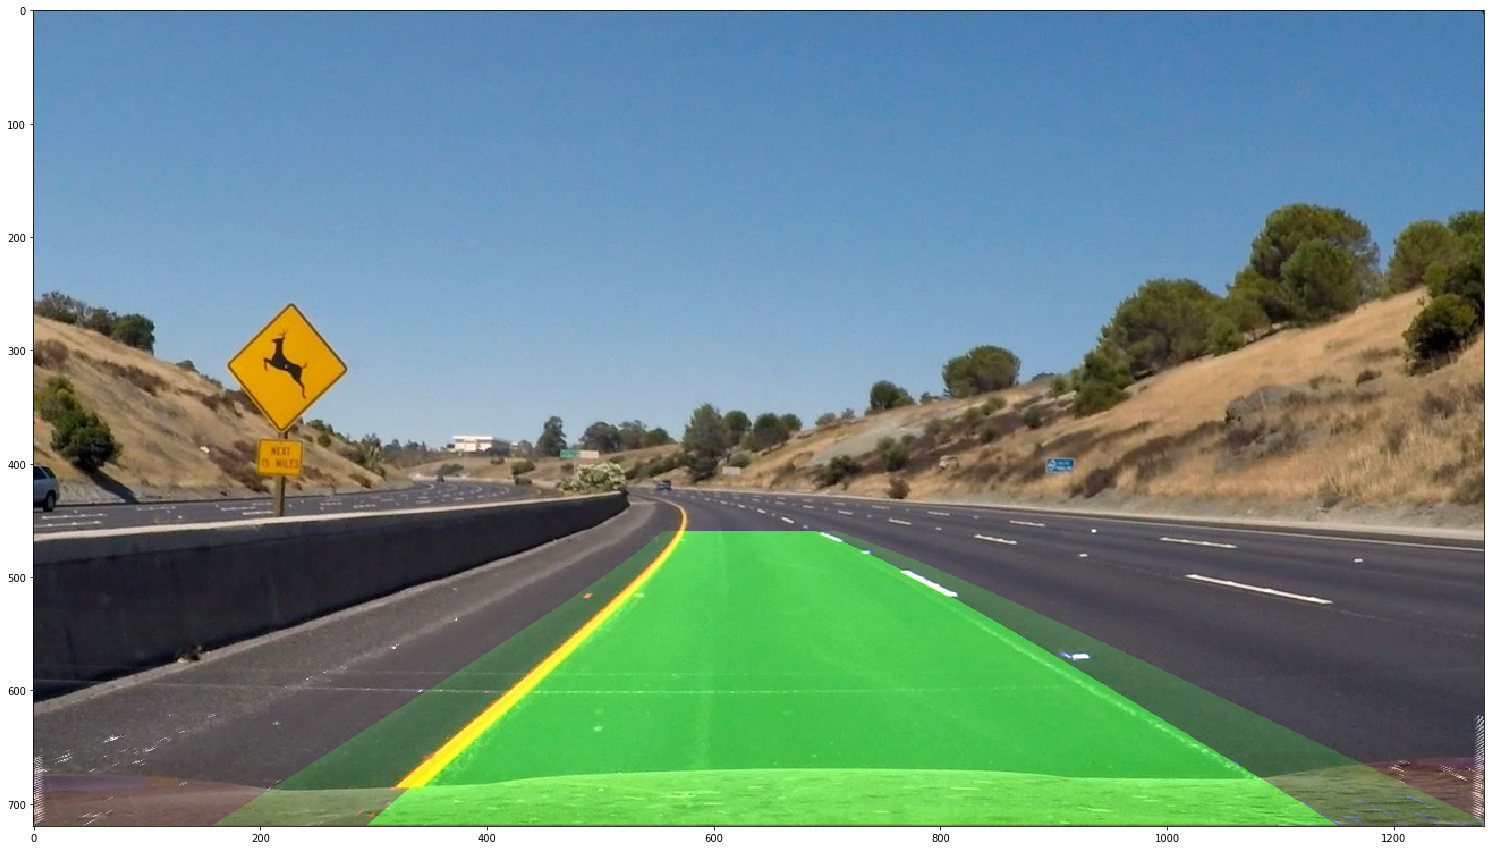

In [59]:
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(result, Minv2, (img_size[0], img_size[1])) 

newwarp = np.uint8(newwarp)

# Combine the result with the original image
final = cv2.addWeighted(curved2, 1, newwarp, 0.5, 0)
plt.figure(figsize=(26,22))
plt.imshow(final)